In [7]:
import plot_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib
importlib.reload(plot_function)
from PIL import Image
from plot_function import calc_theta,match_points,calc_edge_list,regularize_points,reshape_and_match_image
from plot_function import Local,Search_min

In [2]:
#img = mpimg.imread('../point_data/human_test/for presentation/000000000785.jpg')
point_data=np.load('../point_data/human_test/for presentation/sample_data.npy')
point_edge_list=np.load('../point_data/human_test/for presentation/sample_edge.npy')
x=point_data[:,1]
y=point_data[:,2]
x=x.astype(float)
y=y.astype(float)
raw_points=np.column_stack((x,y))

FileNotFoundError: [Errno 2] No such file or directory: '../point_data/human_test/for presentation/sample_data.npy'

In [140]:
points,points_norm,points_theta=regularize_points(raw_points)

In [8]:
north=Local('north')
south=Local('south')
equator=Local('equator')
ex_equator=Local('ex_equator')

all_locals=Search_min([north,south,equator,ex_equator])

all_locals.set_para()

In [9]:
points_size=len(points)

for direction in all_locals.local_list: 
    print(direction)
    star_data=direction.star_data  
    reshaped_position=direction.reshaped_position
    x,y,lum,HIPnum=star_data[:,0],star_data[:,1],star_data[:,2],star_data[:,3]
    a_x=reshaped_position[:,0]
    a_y=reshaped_position[:,1]
    size=7*np.exp(-1*(lum+2)*np.log(2))
    penalty_of_size=8*np.exp(-5*size*np.log(2)-1)
    direction.min_dist=float('inf')
    for edge in direction.edge_list:
        node1,node2=edge
        star_1=reshaped_position[node1]
        star_2=reshaped_position[node2]
        norm=np.linalg.norm(star_2-star_1)
        theta=calc_theta(star_2-star_1)
        a_points=match_points(points,norm,theta,star_1)
        near_stars=[-1 for _ in range(points_size)]
        dist=0
        for i in range(points_size):
            a_point=a_points[i]
            a_point_x=int(round(a_point[0],0))
            a_point_y=int(round(a_point[1],0))
            #ここの処理は変えたほうがいいかも
            if a_point_x<0 or a_point_x>=direction.dotsize_x or a_point_y<0 or a_point_y>=direction.dotsize_y:
                break
            indice3=direction.near_dot[a_point_y][a_point_x]
            nearest_star=np.array([a_x[indice3],a_y[indice3]]).reshape(-1)
            dist+=np.sum((a_point-nearest_star)**2)/(norm**(2))
            near_stars[i]=indice3
            if dist>direction.min_dist:
                break
            if i==points_size-1:
                shape_penalty_rate=0
                for j in range(points_size):
                    shape_penalty_rate+=penalty_of_size[near_stars[j]]
                    for k in range(j+1,points_size):
                        if near_stars[j]==near_stars[k]:
                            if (j,k) in direction.edge_list:
                                shape_penalty_rate+=0.5
                            else:
                                shape_penalty_rate+=1
                shape_penalty_rate+=norm/30
                dist=dist*(1+shape_penalty_rate)
                if dist>direction.min_dist:
                    break
                direction.min_dist=dist 
                direction.min_stars=near_stars
                direction.min_a_points=a_points
                direction.min_theta=theta
                direction.min_norm=norm
            if dist>direction.min_dist:
                break
    print(direction.min_dist)


NameError: name 'points' is not defined

In [143]:
direction=all_locals.search_min_local()

In [144]:
image_path='../point_data/human_test/for presentation/000000000785.jpg'
resize_rate=direction.min_norm/points_norm
rotate_theta=direction.min_theta-points_theta

In [145]:
reshaped_image_array=reshape_and_match_image(direction,image_path,resize_rate,rotate_theta ,raw_points[0])

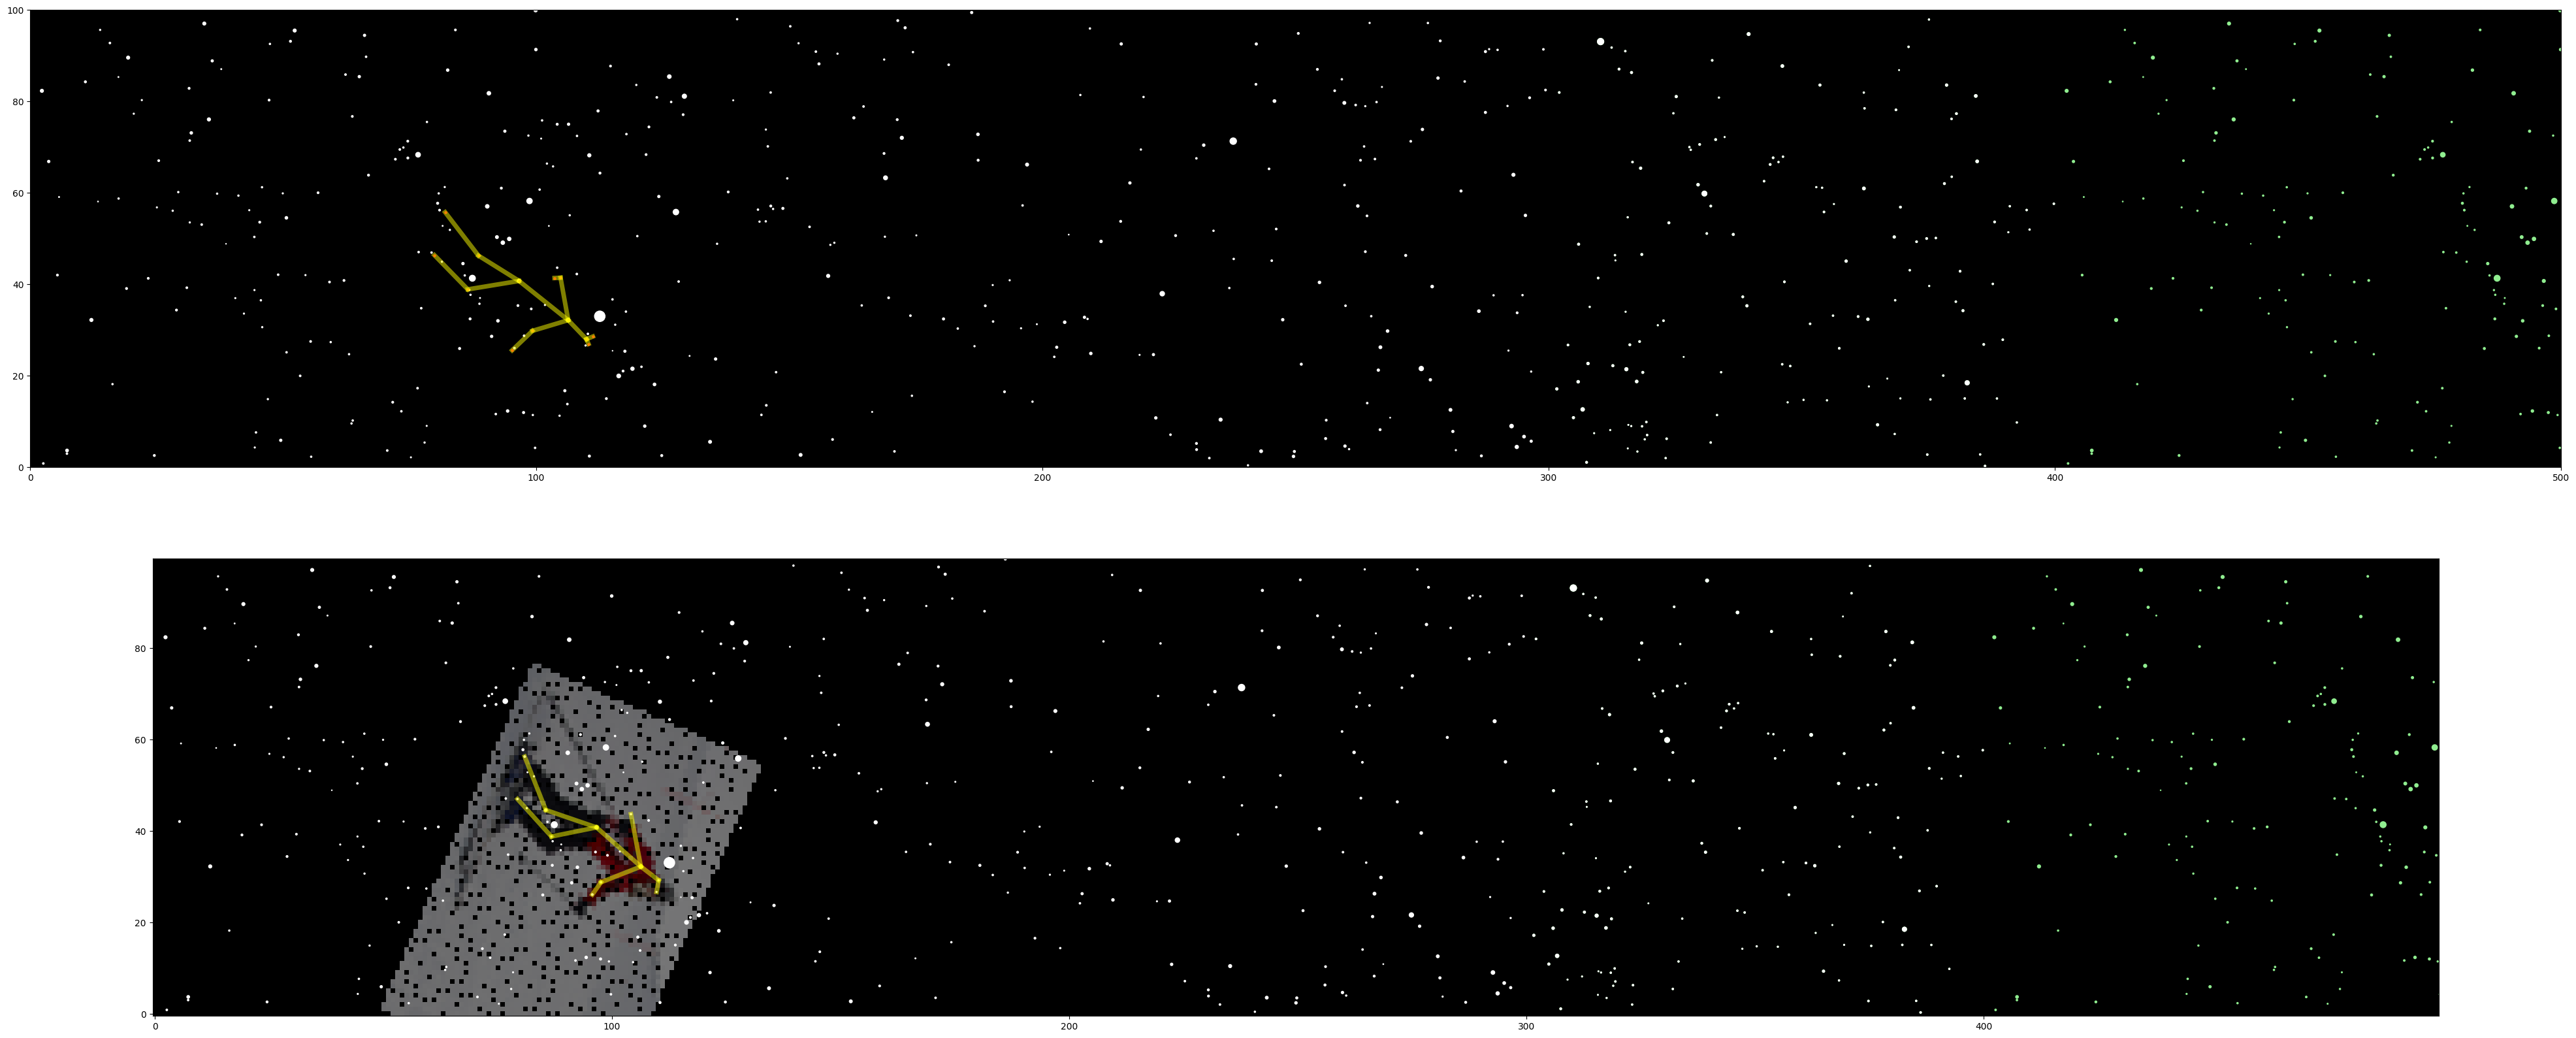

In [146]:
all_locals.show_result(point_edge_list,reshaped_image_array)